In [1]:
import pandas as  pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl
plt.style.use('seaborn-talk')

#### Let's load the datasets

In [2]:
eval_data_dir = '/home/woody/caph/mppi067h/gamma_ray_reconstruction_with_ml/gnn/eval_datasets/phase2d3/'
plots_dir = '/home/woody/caph/mppi067h/gamma_ray_reconstruction_with_ml/gnn/plots/phase2d3/'

In [3]:
analysis_type = 'hybrid'

In [4]:
test_df = pd.read_pickle(eval_data_dir + analysis_type + "/test_final.pkl")  
val_df = pd.read_pickle(eval_data_dir + analysis_type + "/val_final.pkl")  
train_df = pd.read_pickle(eval_data_dir + analysis_type + "/train_final.pkl")  

In [5]:
test_df.shape, val_df.shape, train_df.shape

((40000, 13), (40000, 13), (160000, 13))

In [6]:
test_df.head(5)

,tel_count,is_ct5,obs_id,event_id,true_energy,true_alt,true_az,true_core_x,true_core_y,true_h_first_int,true_x_max,true_shower_primary_id,score
0,5.0,1.0,9191.0,4051217.0,0.589218,68.633286,176.715845,104.590744,81.485970,27317.777344,242.549026,1.0,0.973676
1,4.0,1.0,9191.0,4054408.0,0.991362,70.352895,185.738867,-153.635483,-148.851669,20147.849609,314.000000,1.0,0.982817
2,5.0,1.0,9191.0,4054409.0,0.991362,70.352895,185.738867,-88.161896,-181.356079,20147.849609,314.000000,1.0,0.990819
3,3.0,1.0,9191.0,4093211.0,0.085406,69.660348,184.561861,-28.917500,-94.452385,12211.988281,366.666656,1.0,0.516276
4,5.0,1.0,9191.0,4158109.0,77.412209,69.879747,183.304423,191.222260,-181.974915,28928.070312,391.485321,1.0,0.999907


#### check if there are comment events in datasets

In [7]:
train_val_df = pd.merge(val_df, train_df,  how='outer', on=['obs_id','event_id','true_shower_primary_id','true_alt', 'true_az'])
train_val_df.shape

(200000, 21)

In [8]:
final_df = pd.merge(train_val_df, test_df,  how='outer', on=['obs_id','event_id','true_shower_primary_id','true_alt', 'true_az'])
final_df.shape

(240000, 29)

In [9]:
final_df_gamma = final_df.loc[(final_df['true_shower_primary_id'] == 1)]
final_df_proton = final_df.loc[(final_df['true_shower_primary_id'] == 0)]

In [10]:
final_df_gamma.shape, final_df_proton.shape

((120000, 29), (120000, 29))

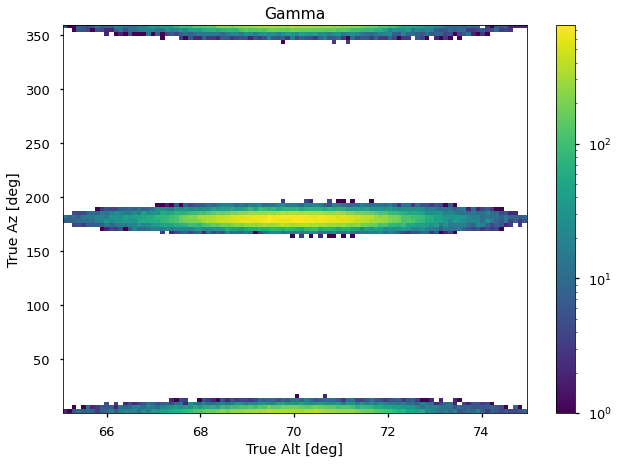

In [11]:
plt.hist2d(final_df_gamma.true_alt, final_df_gamma.true_az, bins=[100,100], norm=mpl.colors.LogNorm(),cmap=mpl.cm.viridis);
plt.colorbar()
plt.title('Gamma')
plt.xlabel('True Alt [deg]')
plt.ylabel('True Az [deg]')
plt.savefig(plots_dir + '/' + analysis_type + '/Gamma_alt_az.pdf',bbox_inches='tight')
plt.savefig(plots_dir + '/' + analysis_type + '/Gamma_alt_az.png',bbox_inches='tight')

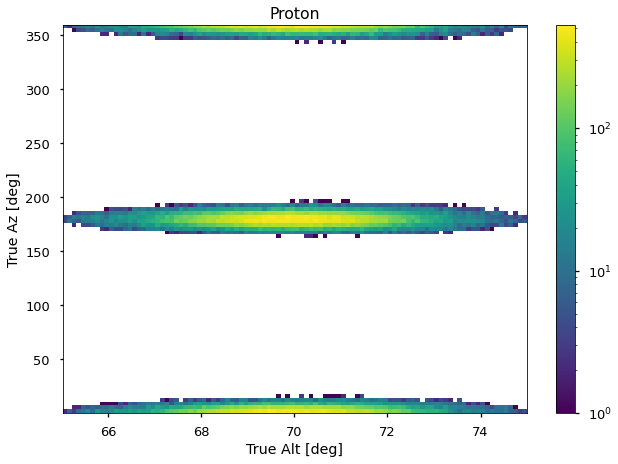

In [12]:
plt.hist2d(final_df_proton.true_alt, final_df_proton.true_az, bins=[100,100], norm=mpl.colors.LogNorm(),cmap=mpl.cm.viridis);
plt.colorbar()
plt.title('Proton')
plt.xlabel('True Alt [deg]')
plt.ylabel('True Az [deg]')
plt.savefig(plots_dir + '/' + analysis_type + '/Proton_alt_az.pdf',bbox_inches='tight')
plt.savefig(plots_dir + '/' + analysis_type + '/Proton_alt_az.png',bbox_inches='tight')

#### investigate the test dataset in more details

In [13]:
test_proton_df = test_df.loc[(test_df['true_shower_primary_id'] == 0)]
test_gamma_df = test_df.loc[(test_df['true_shower_primary_id'] == 1)]

In [14]:
test_proton_df.shape, test_gamma_df.shape

((20000, 13), (20000, 13))

In [15]:
test_gamma_df.head(1)

,tel_count,is_ct5,obs_id,event_id,true_energy,true_alt,true_az,true_core_x,true_core_y,true_h_first_int,true_x_max,true_shower_primary_id,score
0,5.0,1.0,9191.0,4051217.0,0.589218,68.633286,176.715845,104.590744,81.48597,27317.777344,242.549026,1.0,0.973676


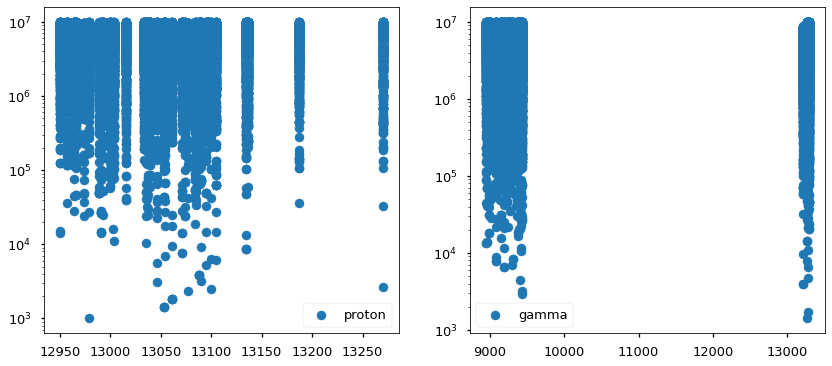

In [16]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[0].scatter(test_proton_df.obs_id, test_proton_df.event_id, label='proton')
ax[0].set_yscale('log')
ax[0].legend()
ax[1].scatter(test_gamma_df.obs_id, test_gamma_df.event_id, label='gamma')
ax[1].set_yscale('log')
ax[1].legend()

In [17]:
eBinsStart = [0.05,0.1,0.3,0.5,1.0,2.0,5.0]
eBinsEnd = [0.1,0.3,0.5,1.0,2.0,5.0,250.]

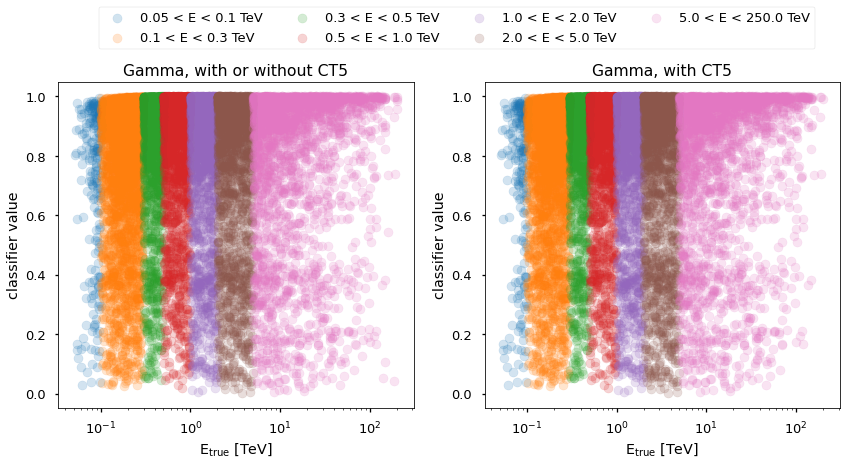

In [18]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
for i in range(7):
    cut = f'true_energy > {eBinsStart[i]} & true_energy <= {eBinsEnd[i]}'
    gamma_df = test_gamma_df.query(cut)
    ax[0].scatter(gamma_df.true_energy, gamma_df.score, label=f'{eBinsStart[i]} < E < {eBinsEnd[i]} TeV', alpha=0.2)
    cut = f'true_energy > {eBinsStart[i]} & true_energy <= {eBinsEnd[i]}  & is_ct5 == 1'
    gamma_df = test_gamma_df.query(cut)
    ax[1].scatter(gamma_df.true_energy, gamma_df.score, label=f'{eBinsStart[i]} < E < {eBinsEnd[i]} TeV', alpha=0.2)
ax[0].legend(loc='upper right',ncol=4, bbox_to_anchor=(2.15, 1.25))
ax[0].set_xscale('log')
ax[0].set_title('Gamma, with or without CT5')
ax[0].set_xlabel('E$_{\mathrm {true}}$ [TeV]');
ax[0].set_ylabel('classifier value');

ax[1].set_title('Gamma, with CT5')
ax[1].set_xscale('log')
ax[1].set_xlabel('E$_{\mathrm {true}}$ [TeV]');
ax[1].set_ylabel('classifier value');
plt.savefig(plots_dir + '/' + analysis_type + '/gamma_classifier_bump.pdf',bbox_inches='tight')
plt.savefig(plots_dir + '/' + analysis_type + '/gamma_classifier_bump.png',bbox_inches='tight')

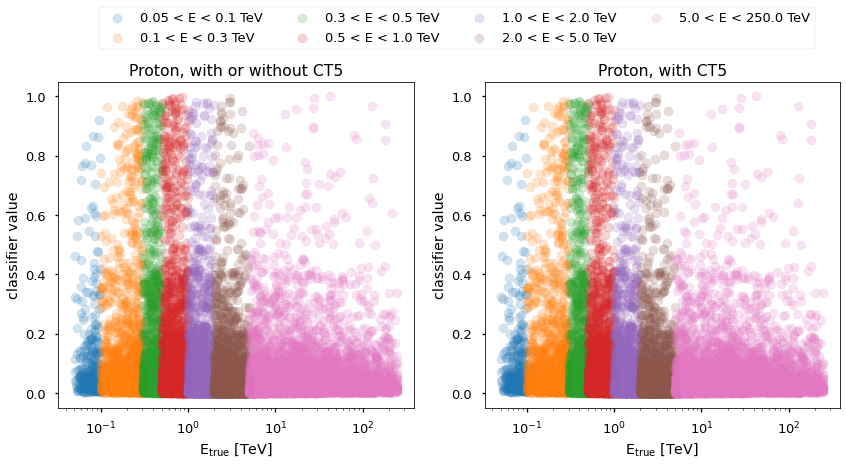

In [19]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
for i in range(7):
    cut = f'true_energy > {eBinsStart[i]} & true_energy <= {eBinsEnd[i]}'
    proton_df = test_proton_df.query(cut)
    ax[0].scatter(proton_df.true_energy, proton_df.score, label=f'{eBinsStart[i]} < E < {eBinsEnd[i]} TeV', alpha=0.2)
    cut = f'true_energy > {eBinsStart[i]} & true_energy <= {eBinsEnd[i]}  & is_ct5 == 1'
    proton_df = test_proton_df.query(cut)
    ax[1].scatter(proton_df.true_energy, proton_df.score, label=f'{eBinsStart[i]} < E < {eBinsEnd[i]} TeV', alpha=0.2)
ax[0].legend(loc='upper right',ncol=4, bbox_to_anchor=(2.15, 1.25))
ax[0].set_xscale('log')
ax[0].set_title('Proton, with or without CT5')
ax[0].set_xlabel('E$_{\mathrm {true}}$ [TeV]');
ax[0].set_ylabel('classifier value');

ax[1].set_title('Proton, with CT5')
ax[1].set_xscale('log')
ax[1].set_xlabel('E$_{\mathrm {true}}$ [TeV]');
ax[1].set_ylabel('classifier value');
plt.savefig(plots_dir + '/' + analysis_type + '/proton_classifier_bump.pdf',bbox_inches='tight')
plt.savefig(plots_dir + '/' + analysis_type + '/proton_classifier_bump.png',bbox_inches='tight')

In [20]:
cut = f'is_ct5 == 0'
print('Gamma: CT5 not present for', test_gamma_df.query(cut).shape[0]*100/test_gamma_df.shape[0],'% of events.')
print('Proton: CT5 not present for',test_proton_df.query(cut).shape[0]*100/test_gamma_df.shape[0],'% of events.')

Gamma: CT5 not present for 6.53 % of events.
Proton: CT5 not present for 3.95 % of events.


#### make the combined ROC curves for hybrid, stereo, mono

In [21]:
def plot_classifier(ax, pred, label, name, color):
    ax.hist(pred[label==0], bins=100, histtype='step', lw=2, linestyle='--', color=color);
    ax.hist(pred[label==1], bins=100, label=name, histtype='step', lw=2, linestyle='-', color=color);
    return ax

In [22]:
def plot_roc_curve(ax, pred, label, name):
    fpr, tpr, thresholds = roc_curve(label, pred)
    roc_auc_train = auc(fpr, tpr)
    ax[0].plot(fpr, tpr, label= name + f' AUC = {roc_auc_train:.4f}')
    ax[0].plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax[1].loglog(fpr, tpr)
    ax[1].loglog([0.001, 1], [0.001, 1], color="navy", linestyle="--")
    return ax

In [23]:
analysis_types = ['mono','stereo', 'hybrid']
combined_dataset = dict()
for analysis_type in analysis_types:
    df = pd.read_pickle(eval_data_dir + analysis_type + "/test_final.pkl")  
    combined_dataset[analysis_type] = [np.array(df.score), np.array(df.true_shower_primary_id)]

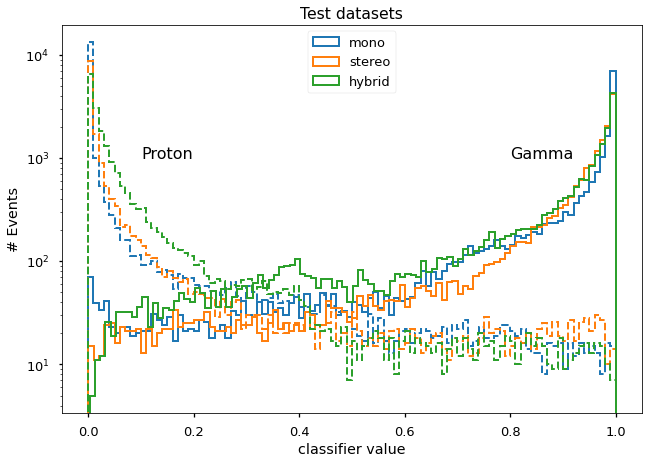

In [24]:
fig, ax = plt.subplots()
for key in combined_dataset.keys():  
    color = next(ax._get_lines.prop_cycler)['color']
    ax = plot_classifier(ax, combined_dataset[key][0], combined_dataset[key][1], key, color)
ax.set_yscale('log')
ax.set_ylabel('# Events')
ax.set_xlabel('classifier value')
ax.legend(loc='upper center')
ax.text(0.1,1e3,'Proton',fontsize=16)
ax.text(0.8,1e3,'Gamma', fontsize=16)
ax.set_title('Test datasets')
plt.savefig(plots_dir + '/' + 'classifier_output.pdf',bbox_inches='tight')
plt.savefig(plots_dir + '/' + 'classifier_output.png',bbox_inches='tight')

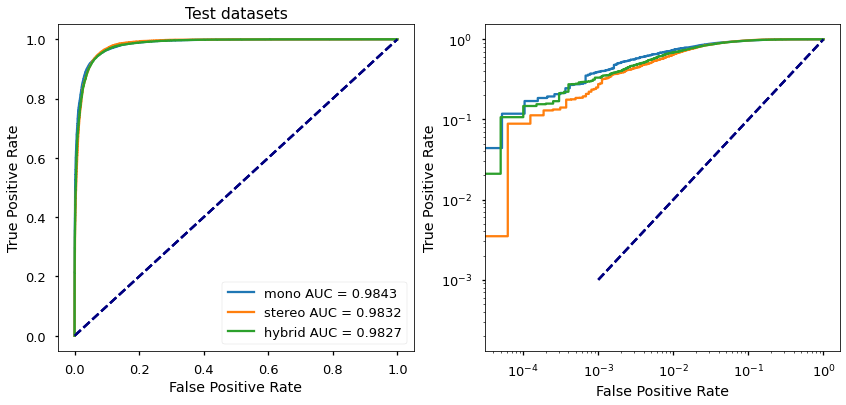

In [25]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
for key in combined_dataset.keys():  
    ax = plot_roc_curve(ax, combined_dataset[key][0], combined_dataset[key][1], key)
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].legend(loc="lower right")
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[0].set_title('Test datasets')
plt.savefig(plots_dir+'/roc_curve.pdf',bbox_inches='tight')
plt.savefig(plots_dir+'/roc_curve.png',bbox_inches='tight')

In [27]:
combined_dataset_energy_bins = list()
for i in range(len(eBinsStart)):
    analysis_types = ['mono','stereo', 'hybrid']
    combined_dataset = dict()
    for analysis_type in analysis_types:
        df = pd.read_pickle(eval_data_dir + analysis_type + "/test_final.pkl") 
        cut = f'true_energy > {eBinsStart[i]} & true_energy <= {eBinsEnd[i]}'
        df.query(cut, inplace=True)
        combined_dataset[analysis_type] = [np.array(df.score), np.array(df.true_shower_primary_id)]
    combined_dataset_energy_bins.append(combined_dataset)

Text(0.5, 1.0, 'Test datasets')

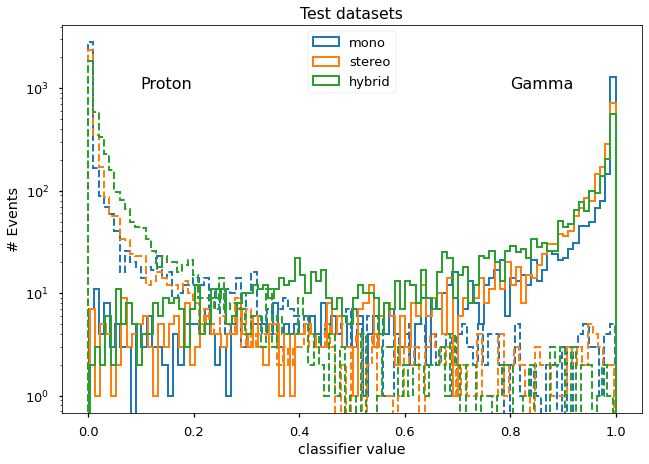

In [53]:
energy_bin = 5
fig, ax = plt.subplots()
combined_dataset = combined_dataset_energy_bins[energy_bin]
for key in combined_dataset.keys():  
    color = next(ax._get_lines.prop_cycler)['color']
    ax = plot_classifier(ax, combined_dataset[key][0], combined_dataset[key][1], key, color)
ax.set_yscale('log')
ax.set_ylabel('# Events')
ax.set_xlabel('classifier value')
ax.legend(loc='upper center')
ax.text(0.1,1e3,'Proton',fontsize=16)
ax.text(0.8,1e3,'Gamma', fontsize=16)
ax.set_title('Test datasets')
# plt.savefig(plots_dir + '/' + 'classifier_output_ebin.pdf',bbox_inches='tight')
# plt.savefig(plots_dir + '/' + 'classifier_output.png',bbox_inches='tight')

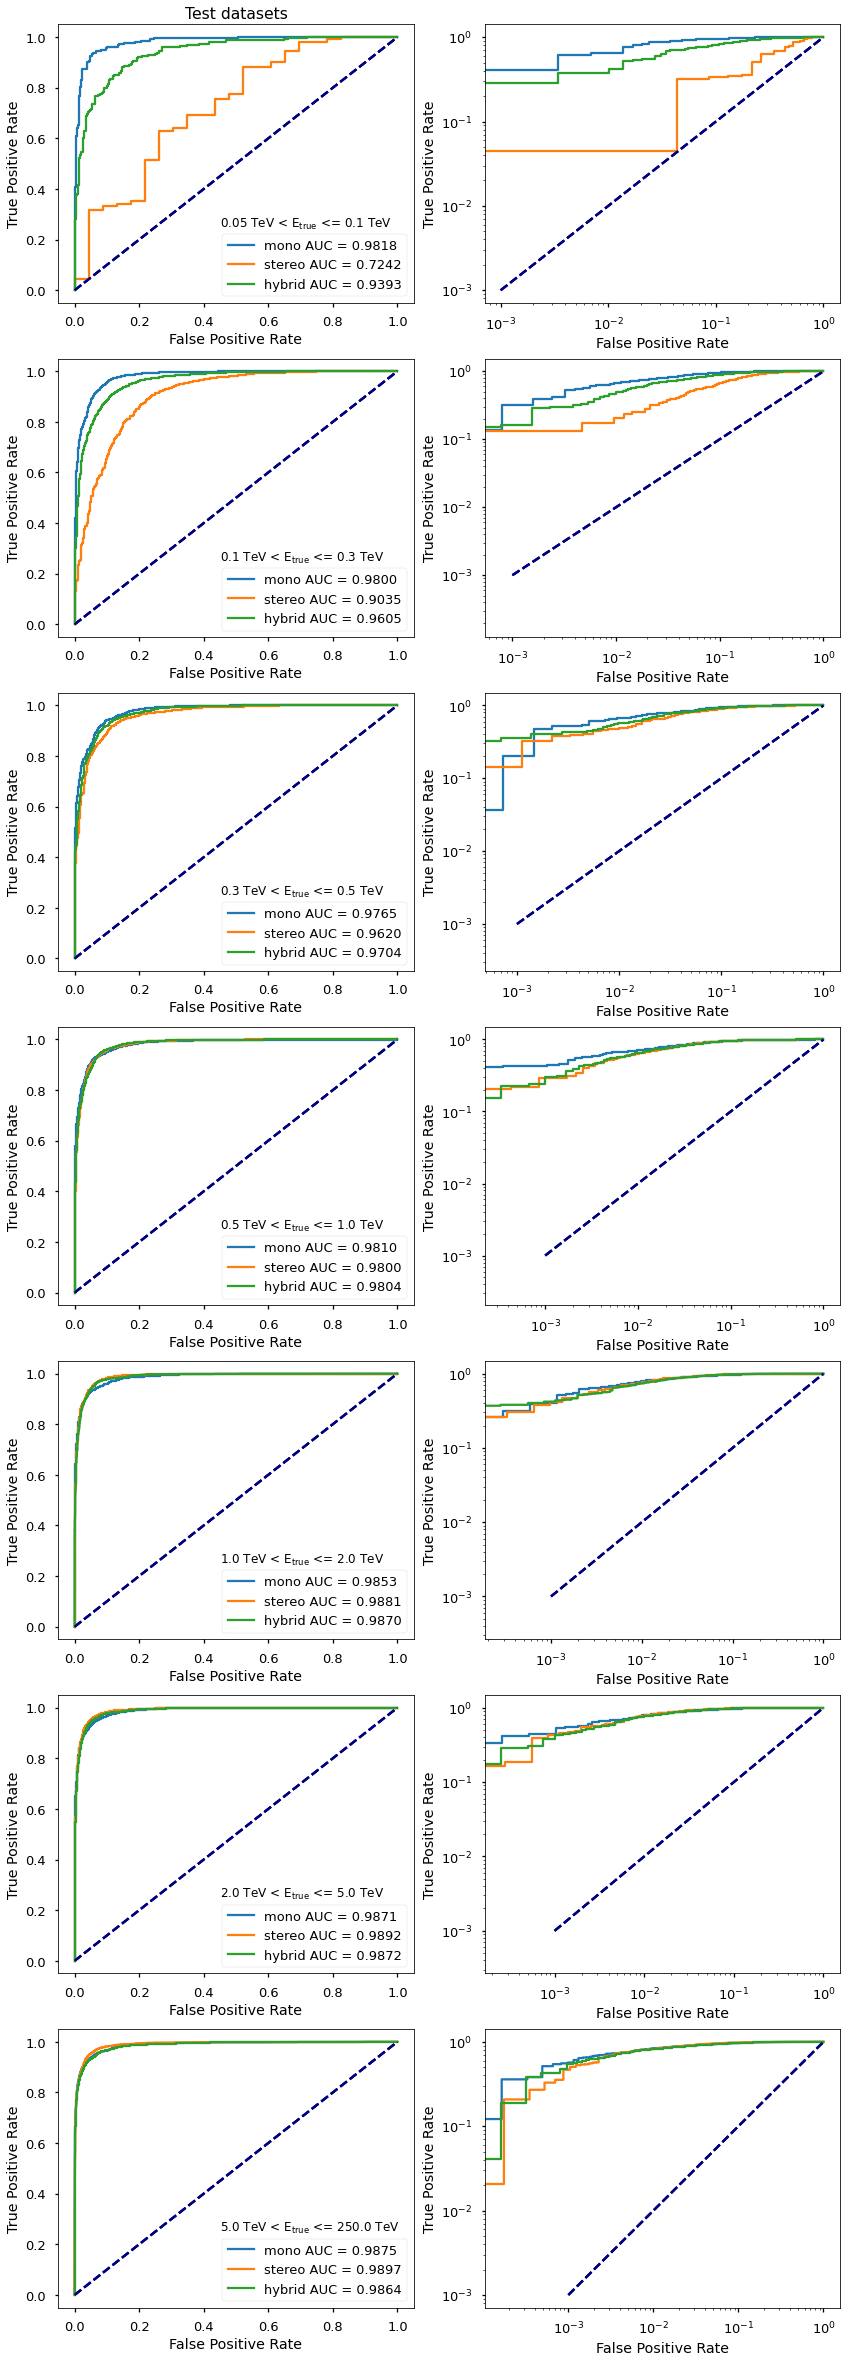

In [54]:
fig, axs = plt.subplots(7,2, figsize=(14,42))
for i in range(7):
    combined_dataset = combined_dataset_energy_bins[i]
    for key in combined_dataset.keys():  
        axs[i] = plot_roc_curve(axs[i], combined_dataset[key][0], combined_dataset[key][1], key)
    axs[i][0].set_xlabel("False Positive Rate")
    axs[i][0].set_ylabel("True Positive Rate")
    axs[i][0].legend(loc="lower right")
    energy_range = f'{eBinsStart[i]} TeV < ' + r'E$_{\rm true}$ ' + f'<= {eBinsEnd[i]} TeV'
    axs[i][0].text(0.45,0.25,energy_range, fontsize=12)
    axs[i][1].set_xlabel("False Positive Rate")
    axs[i][1].set_ylabel("True Positive Rate")
    if(i == 0):
        axs[i][0].set_title('Test datasets')
plt.savefig(plots_dir+'/energy_dependent_roc_curves.pdf',bbox_inches='tight')
plt.savefig(plots_dir+'/energy_dependent_roc_curves.png',bbox_inches='tight')